In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, make_scorer

import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.interpolate import UnivariateSpline

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn import over_sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

import warnings

warnings.filterwarnings("ignore")

In [3]:
# drop num and G column
train = pd.read_csv("/Users/jinx/code/Rs/train.csv").sample(frac=1).reset_index(drop=True)
test = pd.read_csv("/Users/jinx/code/Rs/test.csv")

X_train = train.drop(columns=['diagnosis'])
y_train = train['diagnosis']
X_test = test.drop(columns=['diagnosis'])
y_test = test['diagnosis']

print("X_train.shape:", X_train.shape, ", X_test.shape:", X_test.shape)

X_train.shape: (182, 20) , X_test.shape: (77, 20)


In [40]:
num_cols = X_train.columns.tolist()
num_cols.remove('Gender')
numeric_pipeline = Pipeline([
    ('scaling', RobustScaler())
])

cat_cols = ['Gender']
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse=False))
])

# --- Combine Both Pipelines into Transformer ---
preprocessor = ColumnTransformer([
    # ('numerical', numeric_pipeline, num_cols),
    ('categorical', cat_pipeline, cat_cols)
], remainder='passthrough')

# --- Apply Transformer to Pipeline ---
process_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# --- Apply to Dataframe ---
x_train_process = process_pipeline.fit_transform(X_train)
x_test_process = process_pipeline.fit_transform(X_test)

In [41]:
x_train_process

array([[ 0.  ,  1.  ,  0.  , ...,  1.04, 36.  ,  4.  ],
       [ 1.  ,  0.  ,  1.  , ...,  0.96, 36.2 ,  1.4 ],
       [ 0.  ,  1.  ,  1.  , ...,  1.02, 35.8 ,  2.  ],
       ...,
       [ 0.  ,  1.  ,  1.  , ...,  1.03, 36.1 ,  5.5 ],
       [ 1.  ,  0.  ,  0.  , ...,  0.94, 36.9 ,  1.27],
       [ 1.  ,  0.  ,  1.  , ...,  0.88, 34.5 ,  9.12]])

## 类别数量

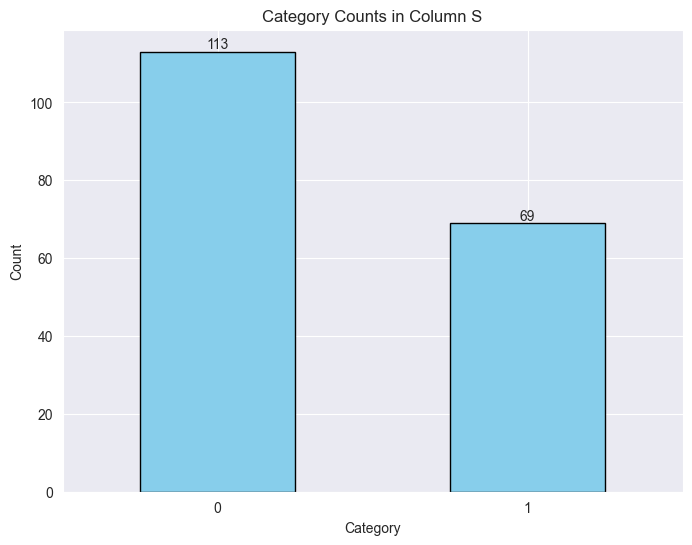

In [35]:
value_counts = y_train.value_counts()
plt.figure(figsize=(8, 6))
ax = value_counts.plot(kind='bar', color='skyblue', edgecolor='black')

for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.title('Category Counts in Column S')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # 设置x轴标签的旋转角度
plt.show()

## 没有参数搜索

In [42]:
samplers = {
    "no": -1,
    "random": over_sampling.RandomOverSampler(random_state=42),
    "smote": over_sampling.SMOTE(random_state=42),
    "adasyn": over_sampling.ADASYN(random_state=42),
    "SVMSMOTE": over_sampling.SVMSMOTE(random_state=42),
    "KMeansSMOTE": over_sampling.KMeansSMOTE(random_state=42),
    "BorderlineSMOTE": over_sampling.BorderlineSMOTE(random_state=42),
    "SMOTETomek": SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    # "SMOTENC": over_sampling.SMOTENC(random_state=42)
}

models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'xgboost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42),
    # 'xgboost2': xgb.XGBClassifier(use_label_encoder=True, eval_metric='auc', random_state=42),
    'lightGBM': lgb.LGBMClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50, 8),  # 设置隐藏层的神经元数量和层数
                         activation='relu',  # 激活函数为 ReLU
                         solver='adam',  # 优化器为 Adam
                         alpha=0.0001,  # L2正则化参数
                         max_iter=10000,  # 最大迭代次数
                         random_state=42),
}

results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
model_categories = [model_name for model_name, _ in models.items()]
aucs = {
    sampler_name: [] for sampler_name, _ in samplers.items()
}

# 4. 训练模型并保存结果
for model_name, model in models.items():
    for sampler_name, sp in samplers.items():
        if sampler_name != "no":
            X_tmp, y_tmp = sp.fit_resample(x_train_process, y_train)
            model.fit(X_tmp, y_tmp)
        else:
            model.fit(x_train_process, y_train)

        y_pred = model.predict(x_test_process)
        y_probs = model.predict_proba(x_test_process)[:, 1]  # 获得预测为正类的概率
        train_pred = model.predict(x_train_process)

        train_accuracy = accuracy_score(y_train, train_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_probs)

        result = pd.DataFrame(
            [[model_name + " + " + sampler_name, train_accuracy, accuracy, precision, recall, f1, auc]],
            columns=['Model', 'Train Accuracy', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
        )
        results = pd.concat([results, result], ignore_index=True)

        # fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc = roc_auc_score(y_test, y_probs)
        aucs[sampler_name].append(auc)

[LightGBM] [Info] Number of positive: 69, number of negative: 113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.379121 -> initscore=-0.493281
[LightGBM] [Info] Start training from score -0.493281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [44]:
results

,Model,Train Accuracy,Accuracy,Precision,Recall,F1 Score,AUC
0,SVM + no,0.824176,0.714286,0.712657,0.687847,0.691327,0.718750
1,SVM + random,0.796703,0.753247,0.755000,0.730208,0.735395,0.752778
2,SVM + smote,0.829670,0.753247,0.747486,0.739236,0.742112,0.751389
3,SVM + adasyn,0.818681,0.740260,0.732979,0.728125,0.730014,0.745139
4,SVM + SVMSMOTE,0.807692,0.766234,0.760284,0.754861,0.757013,0.754167
...,...,...,...,...,...,...,...
59,MLP + adasyn,0.703297,0.662338,0.720896,0.602778,0.574405,0.709722
60,MLP + SVMSMOTE,0.763736,0.636364,0.632172,0.589583,0.576258,0.729167
61,MLP + KMeansSMOTE,0.741758,0.675325,0.734848,0.618403,0.596690,0.718056
62,MLP + BorderlineSMOTE,0.708791,0.649351,0.666466,0.596181,0.576147,0.742014


In [39]:
results

,Model,Train Accuracy,Accuracy,Precision,Recall,F1 Score,AUC
0,SVM + no,0.818681,0.779221,0.818058,0.743403,0.750809,0.735764
1,SVM + random,0.785714,0.792208,0.803459,0.768056,0.775510,0.779167
2,SVM + smote,0.829670,0.714286,0.708899,0.692361,0.695761,0.747222
3,SVM + adasyn,0.807692,0.740260,0.734694,0.723611,0.726950,0.777083
4,SVM + SVMSMOTE,0.835165,0.779221,0.792673,0.752431,0.759596,0.778472
...,...,...,...,...,...,...,...
59,MLP + adasyn,1.000000,0.701299,0.693333,0.681250,0.684032,0.752083
60,MLP + SVMSMOTE,1.000000,0.740260,0.734694,0.723611,0.726950,0.747917
61,MLP + KMeansSMOTE,1.000000,0.753247,0.750370,0.734722,0.738983,0.714583
62,MLP + BorderlineSMOTE,1.000000,0.714286,0.705674,0.701389,0.703015,0.729861


In [45]:
LogisticRegression?

In [ ]:
samplers = {
    "no": -1,
    "random": over_sampling.RandomOverSampler(random_state=42),
    "smote": over_sampling.SMOTE(random_state=42),
    "adasyn": over_sampling.ADASYN(random_state=42),
    "SVMSMOTE": over_sampling.SVMSMOTE(random_state=42),
    "KMeansSMOTE": over_sampling.KMeansSMOTE(random_state=42),
    "BorderlineSMOTE": over_sampling.BorderlineSMOTE(random_state=42),
    "SMOTETomek": SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    # "SMOTENC": over_sampling.SMOTENC(random_state=42)
}

models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'xgboost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42),
    'lightGBM': lgb.LGBMClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50, 8),  # 设置隐藏层的神经元数量和层数
                         activation='relu',  # 激活函数为 ReLU
                         solver='adam',  # 优化器为 Adam
                         alpha=0.0001,  # L2正则化参数
                         max_iter=10000,  # 最大迭代次数
                         random_state=42),
}

models_param_grid = {
    'SVM': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'RandomForest': {
        'criterion': ["gini", "entropy", "log_loss"],
        'max_depth': np.arange(1, 7, 1),
        'n_estimators': np.arange(20, 120, 20)
    },
    'LogisticRegression': {
        'solver': ["lbfgs", "saga", "newton-cg"],
        'C': [0.1, 0.2, 0.5, 0.8],
        'penalty': ['l1', 'l2', 'elasticnet']
    },
    'xgboost': {
        'n_estimators': [6, 7, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2, 0.4, 0.8],
    },
    'lightGBM': {
        'boosting_type': ['gbdt', 'dart', 'rf'],
        'num_leaves': [31, 50, 100],
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01]
    },
    'DecisionTree': {
        'criterion': ["gini", "entropy", "log_loss"],
    },
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (100, 50, 25), (200, 100, 50)],
            'alpha': [0.0001, 0.001, 0.01],  # 正则化参数
            'learning_rate_init': [0.001, 0.01, 0.1]}
}

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Best Param'])
model_categories = [model_name for model_name, _ in models.items()]
aucs = {
    sampler_name: [] for sampler_name, _ in samplers.items()
}

# 4. 训练模型并保存结果
for model_name, model in models.items():
    for sampler_name, sp in samplers.items():
        if sampler_name != "no":
            X_tmp, y_tmp = sp.fit_resample(x_train_process, y_train)
            grid_search = GridSearchCV(model, models_param_grid[model_name], cv=5, scoring='accuracy')
            grid_search.fit(X_tmp, y_tmp)
            best_params = grid_search.best_params_
            model = grid_search.best_estimator_
            # 重新训练
            model.fit(X_tmp, y_tmp)
        else:
            grid_search = GridSearchCV(model, models_param_grid[model_name], cv=5, scoring='accuracy')
            grid_search.fit(x_train_process, y_train)
            best_params = grid_search.best_params_
            model = grid_search.best_estimator_
            model.fit(x_train_process, y_train)

        y_pred = model.predict(x_test_process)
        y_probs = model.predict_proba(x_test_process)[:, 1]  # 获得预测为正类的概率

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_probs)

        result = pd.DataFrame(
            [[model_name + " + " + sampler_name, accuracy, precision, recall, f1, auc, best_params]],
            columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Best Param']
        )
        results = pd.concat([results, result], ignore_index=True)

        # fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc = roc_auc_score(y_test, y_probs)
        aucs[sampler_name].append(auc)
